# Sparkify Project - Local Mode

This notebook contains code for the Capstopne project prepared for the Udacity Data Science Nanodegree.  
The scope of the project is to use Spark to analyse data coming from a fictious music streaming service ("Sparkify") in order to predict when a user is going to "churn" i.e. cancel from the service. This prediction would allow preventive actions (like, for example, promotion offers or bespoke recommendations).

In order to complete the project, the students were provided with a reduced dataset (128MB) that is used here for an analysis that can be conducted using Spark in local mode on a single machine, while for the full dataset (12GB), the same code would need to run on a more performing cluster.

## Table of Contents

1. [Load libraries ad start Spark session](#Load-Libraries)<br>
2. [Load and Clean Dataset](#Load-and-Clean-Dataset)<br>
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
    3.1. [Time Spent/Number of Songs](#Time-Songs)<br>
    3.2. [Add a Friend/Thumbs Up/Down](#Friends-Thumbs)<br>
    3.3. [Submit an Upgrade/Downgrade request](#Upgrade-Downgrade)<br>
    3.4. [Roll Advert](#Roll-Advert)<br>
    3.5. [Demographics](#Demographics)<br>
4. [Feature Engineering](#Feature-Engineering)<br>
5. [Modeling](#Modeling)<br>
    5.1. [Logistic Regression](#Logistic-Regression)<br>
    5.2. [Gradient-Boosted Tree](#Gradient-Boosted-Tree)<br>
    5.3. [Random Forest](#Random-Forest)<br>
    5.4. [Linear-SVC](#Linear-SVC)<br>
6. [Optimization](#Optimization)<br>
    6.1. [Gradient-Boosted Tree](#Optimized-Gradient-Boosted-Tree)<br>
    6.2. [Random Forest](#Optimized-Random-Forest)<br>

## <a class="anchor" id="Load-Libraries">1. Load libraries and start Spark session</a>

In [1]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .config("spark.driver.bindAddress","localhost")\
    .config("spark.ui.port","4050")\
    .getOrCreate()

## <a class="anchor" id="Load-and-Clean-Dataset">2. Load and Clean Dataset</a>

As said before, for this analysis the mini-dataset file used is `mini_sparkify_event_data.json`.

In [3]:
# Load data
# Mini dataset
path = "../data/mini_sparkify_event_data.json"
df_user_log = spark.read.json(path)

In [4]:
# Check schema
df_user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Show the first row
df_user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
# Check num of rows, columns
print('Num. of rows in the dataset: ', df_user_log.count(), '; Num. of columns: ', len(df_user_log.columns))

Num. of rows in the dataset:  286500 ; Num. of columns:  18


To clean the dataset, we can delete eventual `NaN` in the `userId` and `sessionId` field, and take care of the cases of missing users also:

In [7]:
# Drop NaN in userId and sessionId
df_user_log_valid = df_user_log.dropna(how = "any", subset = ["userId", "sessionId"])

# Drop NaN in gender and location
df_user_log_valid = df_user_log.dropna(how = "any", subset = ["gender", "location"])

# Drop empty users
df_user_log_valid = df_user_log_valid.filter(df_user_log_valid["userId"] != "")

In [8]:
# Check num of rows remaining
print('Num. of rows in the valid dataset: ', df_user_log_valid.count())

Num. of rows in the valid dataset:  278154


## <a class="anchor" id="Exploratory-Data-Analysis">3. Exploratory Data Analysis</a>

In this phase we'll mainly look at the data and try to get familiar with it, to see what kind of trends or interesting information might be available afterwards to work on feature engineering.

A cell that seems to provide quite a bit of useful information is `page`, that documents the various pages visited by the users:

In [9]:
# Check available pages
df_user_log_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Based on the type of information available in this column, we can define new variables identifying, for example, an actual churn (looking at when the users visits `Cancellation Confirmation`) or an Upgrade/Downgrade, but also events like the user giving a Thumbs Up or adding friends, or seeing a Rolling Advert.  
We can also recontruct the time spent by the users with the system, making reference to the `registration` and `ts` columns.

In [10]:
# Defining a churn variable based on the Cancellation Confirmation page
cancellation = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("churn", cancellation("page"))

In [11]:
# Defining a sub_dwg variable based on the Submit Downgrade page
submit_dwg = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_user_log_valid = df_user_log_valid.withColumn("sub_dwg", submit_dwg("page"))

In [12]:
# Defining a sub_upg variable based on the Submit Upgrade page
submit_dwg = F.udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df_user_log_valid = df_user_log_valid.withColumn("sub_upg", submit_dwg("page"))

In [13]:
# Getting UNIX time from miliseconds to seconds
df_user_log_valid = df_user_log_valid.withColumn("ts", df_user_log_valid.ts/1000)                        
df_user_log_valid = df_user_log_valid.withColumn("registration", df_user_log_valid.registration/1000)

In [14]:
# Defining a first_ts/last_ts variable showing the timestamp of the first/last entry 
# (Can be used to filter with time, will be used to calculate total duration of the permanence)
window = Window.partitionBy("userId")
df_user_log_valid = df_user_log_valid.withColumn("first_ts", F.min("ts").over(window))
df_user_log_valid = df_user_log_valid.withColumn("last_ts", F.max("ts").over(window))

In [15]:
# Defining a perm_days variable showing the (rounded) number of days a user has spent with the service so far
df_user_log_valid = df_user_log_valid.withColumn("perm_days", \
                                                 F.round((df_user_log_valid.last_ts - df_user_log_valid.registration)\
                                                 /(3600*24)))

In [16]:
# Defining a data_days variable showing the (rounded) number of days of data available for a user
df_user_log_valid = df_user_log_valid.withColumn("data_days", \
                                                 F.round((df_user_log_valid.last_ts - df_user_log_valid.first_ts)\
                                                 /(3600*24)))

In [17]:
# Defining a roll_adv variable based on the Roll Advert page
roll_adv = F.udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("roll_adv", roll_adv("page"))

In [18]:
# Defining a total_rolled_advert variable showing the total of the rolled advert events
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_roll_adv", F.sum("roll_adv").over(window))

In [19]:
# Defining an add_friend variable based on the Add Friend page
add_friend = F.udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("add_friend", add_friend("page"))

In [20]:
# Defining a total_add_friend variable showing the total of the friends added
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_add_friend", F.sum("add_friend").over(window))

In [21]:
# Defining a thumbs_up variable based on the Thumbs Up page
thumbs_up = F.udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("thumbs_up", thumbs_up("page"))

In [22]:
# Defining a total_thumbs_up variable showing the total of the Thumbs Up given
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_thumbs_up", F.sum("thumbs_up").over(window))

In [23]:
# Defining a thumbs_dwm variable based on the Thumbs Down page
thumbs_dwn = F.udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("thumbs_dwn", thumbs_dwn("page"))

In [24]:
# Defining a total_thumbs_dwn variable showing the total of the Thumbs Down given
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_thumbs_dwn", F.sum("thumbs_dwn").over(window))

In [25]:
# Check columns
df_user_log_valid.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340.0, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534.0, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, sub_dwg=0, sub_upg=0, first_ts=1539003534.0, last_ts=1542823952.0, perm_days=56.0, data_days=44.0, roll_adv=0, total_roll_adv=52, add_friend=0, total_add_friend=4, thumbs_up=0, total_thumbs_up=17, thumbs_dwn=0, total_thumbs_dwn=5)

To gain significance, we can focus the analysis on users that have at least some contwnt to analyse, for example at least a week of data.

In [26]:
# We can remove from the dataframe users that have less than a week of data
df_user_log_valid = df_user_log_valid.filter(df_user_log_valid.data_days >= 7)       

In [27]:
# Check num of rows remaining
print('Num. of rows in the filtered dataset: ', df_user_log_valid.count())

Num. of rows in the filtered dataset:  275924


We can build now two datasets, one with the users that left vs. the other with the users that are staying:

In [28]:
# Create a list of users that cancelled vs. users that stayed
users_cancelled = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 1).dropDuplicates().collect()
users_staying = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 0).dropDuplicates().collect()

In [29]:
# Check num of users in both datasets
print('Num. of users that left: ', len(users_cancelled), \
      '; Num. of users that are staying: ', len(users_staying))

Num. of users that left:  41 ; Num. of users that are staying:  204


In [30]:
# Select a subset of the dataframe with the users that left
users_cancelled_list = [us_c[0] for us_c in users_cancelled]
df_user_log_cancelled = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_cancelled_list))

In [31]:
# Select a subset of the dataframe with the users that stayed
users_staying_list = [us_s[0] for us_s in users_staying]
df_user_log_staying = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_staying_list))

In [32]:
# Check the size of the datasets
print('Num. of rows in the dataset of users that cancelled: ', df_user_log_cancelled.count())
print('Num. of rows in the dataset of users that are staying: ', df_user_log_staying.count())

Num. of rows in the dataset of users that cancelled:  43557
Num. of rows in the dataset of users that are staying:  275924


We can further refine, building datasets focusing on the last week of activity for the users, so to see wether or not there's a change for the users that churn as they approach the moment they would leave:

In [33]:
# Select last week of users that cancelled
df_user_log_cancelled_lweek = df_user_log_cancelled.filter((df_user_log_cancelled.last_ts - \
                                                            df_user_log_cancelled.ts) < (3600*24*7))

In [34]:
# Select last week of users that stay
df_user_log_staying_lweek = df_user_log_staying.filter((df_user_log_staying.last_ts - df_user_log_staying.ts) < \
                                                      (3600*24*7))

In [35]:
# Check the size of the datasets
print('Num. of rows in the dataset of users that cancelled - last week data: ', df_user_log_cancelled_lweek.count())
print('Num. of rows in the dataset of users that are staying - last week data: ', df_user_log_staying_lweek.count())

Num. of rows in the dataset of users that cancelled - last week data:  15287
Num. of rows in the dataset of users that are staying - last week data:  57686


In [36]:
# Create a list of users that cancelled vs. users that stayed in the last week
users_cancelled_lweek = df_user_log_cancelled_lweek.select(["userId"]).dropDuplicates().collect()
users_staying_lweek = df_user_log_staying_lweek.select(["userId"]).dropDuplicates().collect()

In [37]:
# Check num of users in both datasets
print('Num. of users that left - last week data: ', len(users_cancelled_lweek), \
      '; Num. of users that are staying - last week data: ', len(users_staying_lweek))

Num. of users that left - last week data:  41 ; Num. of users that are staying - last week data:  204


As expected, given that we have already filtered only users that have more than one week of data to analyse, we have data for all of them.

### <a class="anchor" id="Time-Songs">3.1. Time spent/Number of Songs</a>

As a first step, we can look at the amount of time spent with the service and at the number of songs listened in a day, comparing the users that cancelled and those that are staying, both looking at the whole dataset and at the last week only.

In [38]:
# Select, for every user that cancelled, the number of songs, the time they spent with the service and the time
# window of tha analysis
song_time_canc = df_user_log_cancelled.\
                filter(df_user_log_cancelled["song"] != "").\
                groupBy("userId").\
                agg(F.max("perm_days"), F.max("data_days"), F.countDistinct("song")).\
                collect()

In [39]:
# Get the time 
delta_time_cancelled = [song_time[1] for song_time in song_time_canc]
# Get the number of songs listened per day (on average)
num_songs_cancelled = [song_time[3]/song_time[2] for song_time in song_time_canc]

In [40]:
# Select, for every user that stays, the number of songs, the time they spent with the service and the time
# window of tha analysis
song_time_stay = df_user_log_staying.\
                filter(df_user_log_staying["song"] != "").\
                groupBy("userId").\
                agg(F.max("perm_days"), F.max("data_days"), F.countDistinct("song")).\
                collect()

In [41]:
# Get the time
delta_time_staying = [song_time[1] for song_time in song_time_stay]
# Get the number of songs listened per day (on average)
num_songs_staying = [song_time[3]/song_time[2] for song_time in song_time_stay]

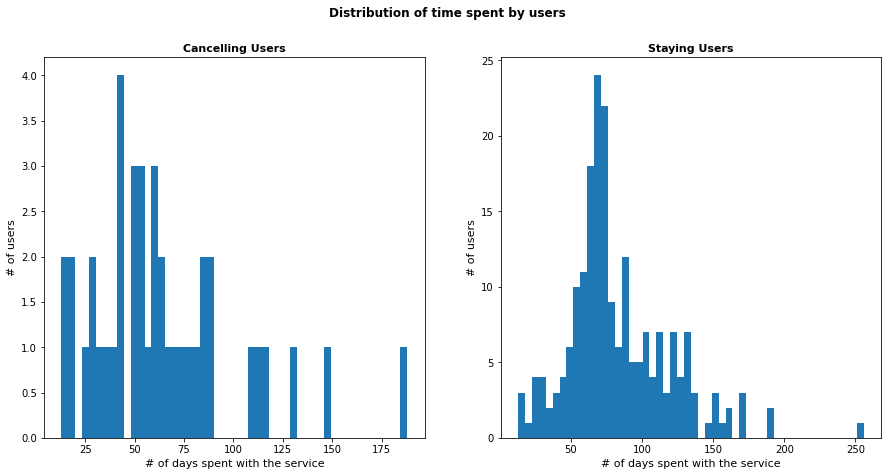

In [42]:
# Plot histogram for time
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of time spent by users ', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(delta_time_cancelled, bins=50)
ax1.set_xlabel('# of days spent with the service', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(delta_time_staying, bins=50)
ax2.set_xlabel('# of days spent with the service', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [43]:
# Look at the statistics
stats_time_canc = spark.createDataFrame(delta_time_cancelled, FloatType()).describe().collect()
stats_time_stay = spark.createDataFrame(delta_time_staying, FloatType()).describe().collect()

print('------------------------------------------------')
print('Time spent statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_time_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_time_canc[2][1])))
print('------------------------------------------------')
print('Time spent statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_time_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_time_stay[2][1])))
print('------------------------------------------------')

------------------------------------------------
Time spent statistics for users that cancelled:
Mean =  63.83 ; Std. Dev. =  36.85
------------------------------------------------
Time spent statistics for users that stay:
Mean =  83.59 ; Std. Dev. =  36.20
------------------------------------------------


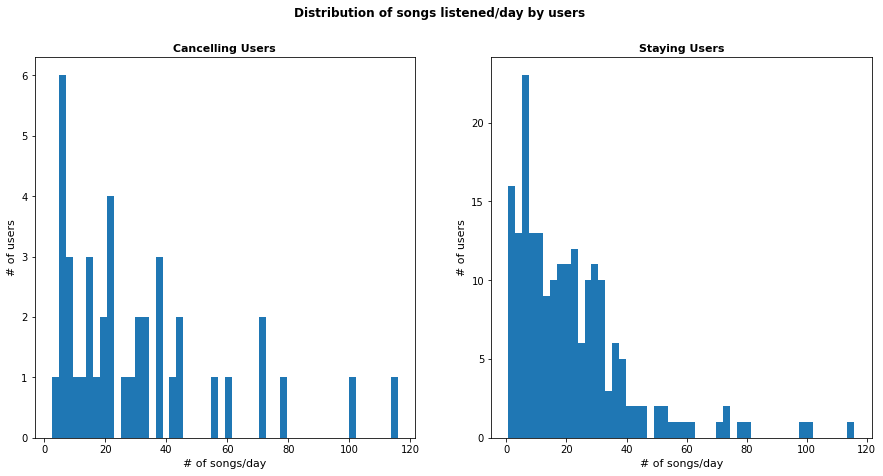

In [44]:
# Plot histogram for songs
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of songs listened/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(num_songs_cancelled, bins=50)
ax1.set_xlabel('# of songs/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(num_songs_staying, bins=50)
ax2.set_xlabel('# of songs/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [45]:
# Look at the statistics
stats_song_canc = spark.createDataFrame(num_songs_cancelled, FloatType()).describe().collect()
stats_song_stay = spark.createDataFrame(num_songs_staying, FloatType()).describe().collect()

print('---------------------------------------------------')
print('Songs per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_song_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_canc[2][1])))
print('---------------------------------------------------')
print('Songs per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_song_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_stay[2][1])))
print('---------------------------------------------------')

---------------------------------------------------
Songs per day statistics for users that cancelled:
Mean =  30.73 ; Std. Dev. =  26.55
---------------------------------------------------
Songs per day statistics for users that stay:
Mean =  21.65 ; Std. Dev. =  18.90
---------------------------------------------------


We can see if anything changes in the last week of permanence:

In [46]:
# Select, for every user that cancelled, the number of songs they listened in the last week
song_time_canc_lweek = df_user_log_cancelled_lweek.\
                filter(df_user_log_cancelled_lweek["song"] != "").\
                groupBy("userId").\
                agg(F.countDistinct("song")).\
                collect()

In [47]:
# Get the number of songs listened per day (on average)
num_songs_cancelled_lweek = [song_time[1]/7 for song_time in song_time_canc_lweek]

In [48]:
# Select, for every user that stays, the number of songs they listened in the last week
song_time_stay_lweek = df_user_log_staying_lweek.\
                filter(df_user_log_staying_lweek["song"] != "").\
                groupBy("userId").\
                agg(F.countDistinct("song")).\
                collect()

In [49]:
# Get the number of songs listened per day (on average)
num_songs_staying_lweek = [song_time[1]/7 for song_time in song_time_stay_lweek]

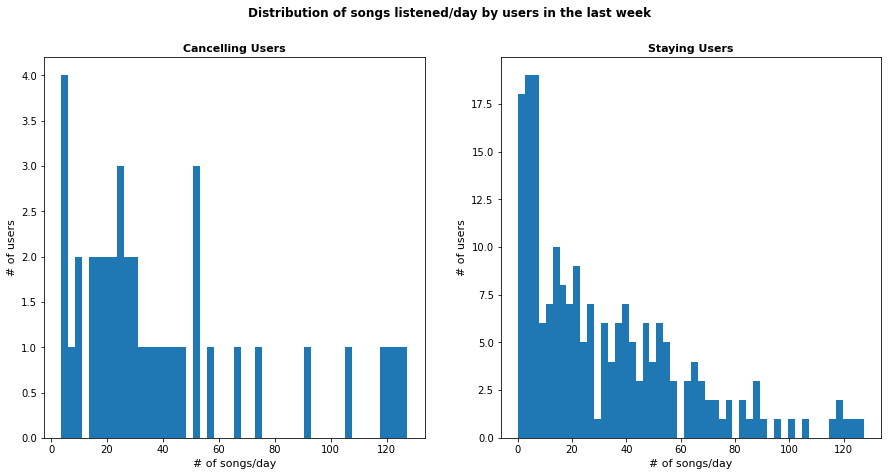

In [50]:
# Plot histogram for songs
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of songs listened/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(num_songs_cancelled_lweek, bins=50)
ax1.set_xlabel('# of songs/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(num_songs_staying_lweek, bins=50)
ax2.set_xlabel('# of songs/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [51]:
# Look at the statistics
stats_song_canc_lweek = spark.createDataFrame(num_songs_cancelled_lweek, FloatType()).describe().collect()
stats_song_stay_lweek = spark.createDataFrame(num_songs_staying_lweek, FloatType()).describe().collect()

print('--------------------------------------------------------------')
print('Songs per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_song_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_canc_lweek[2][1])))
print('--------------------------------------------------------------')
print('Songs per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_song_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_stay_lweek[2][1])))
print('--------------------------------------------------------------')

--------------------------------------------------------------
Songs per day statistics for users that cancelled - last week:
Mean =  41.52 ; Std. Dev. =  35.33
--------------------------------------------------------------
Songs per day statistics for users that stay - last week:
Mean =  31.92 ; Std. Dev. =  29.37
--------------------------------------------------------------


### <a class="anchor" id="Friends-Thumbs">3.2. Add a Friend/Thumbs Up/Down</a>

As another area of interest, we could look into how do the users interact with the service, inviting friends or expressing preferences on songs.

#### 3.2.1. Add a friend

In [52]:
# Select, for every user that cancelled, the number of added friends and the time window of the analysis
added_friend_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_add_friend")).collect()

In [53]:
# Get the number of friends added per day, on average
added_friend_day_canc = [added_friend[2]/added_friend[1] for added_friend in added_friend_canc]

In [54]:
# Select, for every user that is staying, the number of added friends and the time window of the analysis
added_friend_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_add_friend")).collect()

In [55]:
# Get the number of friends added per day, on average
added_friend_day_stay = [added_friend[2]/added_friend[1] for added_friend in added_friend_stay]

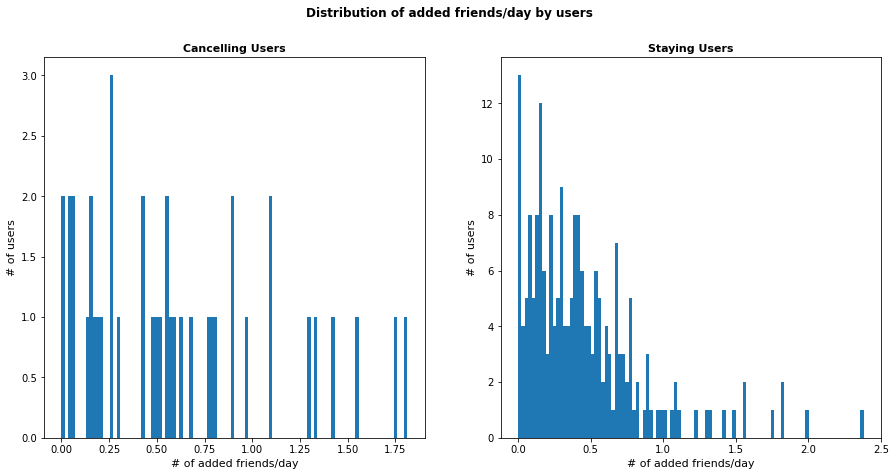

In [56]:
# Plot histogram for added friends
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of added friends/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(added_friend_day_canc, bins=100)
ax1.set_xlabel('# of added friends/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(added_friend_day_stay, bins=100)
ax2.set_xlabel('# of added friends/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [57]:
# Look at the statistics
stats_added_friend_canc = spark.createDataFrame(added_friend_day_canc, FloatType()).describe().collect()
stats_added_friend_stay = spark.createDataFrame(added_friend_day_stay, FloatType()).describe().collect()

print('---------------------------------------------------------')
print('Added friend per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_canc[2][1])))
print('---------------------------------------------------------')
print('Added friend per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_stay[2][1])))
print('---------------------------------------------------------')

---------------------------------------------------------
Added friend per day statistics for users that cancelled:
Mean =  0.60 ; Std. Dev. =  0.50
---------------------------------------------------------
Added friend per day statistics for users that stay:
Mean =  0.46 ; Std. Dev. =  0.40
---------------------------------------------------------


We can check if anything changes during last week:

In [58]:
# Select, for every user that cancelled, the number of added friends in the last week
added_friend_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("add_friend")).collect()

In [59]:
# Get the number of friends added per day, on average
added_friend_day_canc_lweek = [added_friend[1]/7 for added_friend in added_friend_canc_lweek]

In [60]:
# Select, for every user that is staying, the number of added friends in the last week
added_friend_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("add_friend")).collect()

In [61]:
# Get the number of friends added per day, on average
added_friend_day_stay_lweek = [added_friend[1]/7 for added_friend in added_friend_stay_lweek]

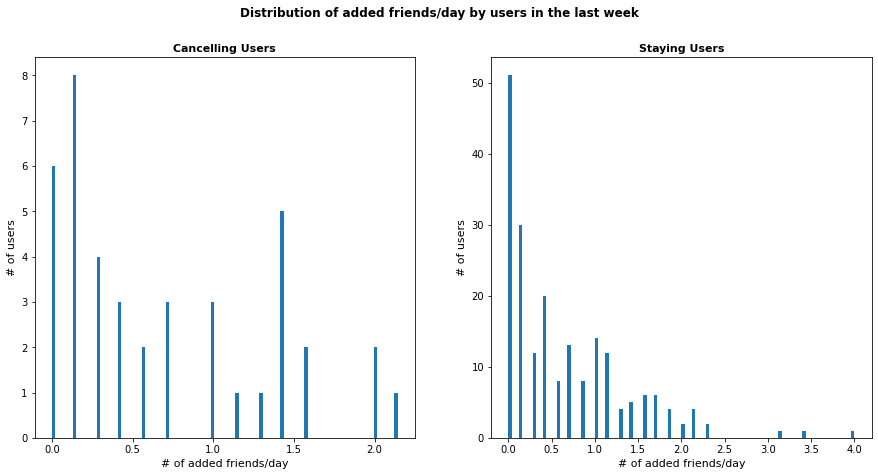

In [62]:
# Plot histogram for added friends
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of added friends/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(added_friend_day_canc_lweek, bins=100)
ax1.set_xlabel('# of added friends/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(added_friend_day_stay_lweek, bins=100)
ax2.set_xlabel('# of added friends/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [63]:
# Look at the statistics
stats_added_friend_canc_lweek = spark.createDataFrame(added_friend_day_canc_lweek, FloatType()).describe().collect()
stats_added_friend_stay_lweek = spark.createDataFrame(added_friend_day_stay_lweek, FloatType()).describe().collect()

print('---------------------------------------------------------------------')
print('Added friend per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_canc_lweek[2][1])))
print('---------------------------------------------------------------------')
print('Added friend per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_stay_lweek[2][1])))
print('---------------------------------------------------------------------')

---------------------------------------------------------------------
Added friend per day statistics for users that cancelled - last week:
Mean =  0.70 ; Std. Dev. =  0.65
---------------------------------------------------------------------
Added friend per day statistics for users that stay - last week:
Mean =  0.65 ; Std. Dev. =  0.71
---------------------------------------------------------------------


#### 3.2.2. Thumbs up

In [64]:
# Select, for every user that cancelled, the number of thumbs up given and the time window of the analysis
thumbs_up_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_up")).collect()

In [65]:
# Get the number of thumbs up given, on average
thumbs_up_day_canc = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_up_canc]

In [66]:
# Select, for every user that is staying, the number of thumbs up given and the time window of the analysis
thumbs_up_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_up")).collect()

In [67]:
# Get the number of thumbs up given, on average
thumbs_up_day_stay = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_up_stay]

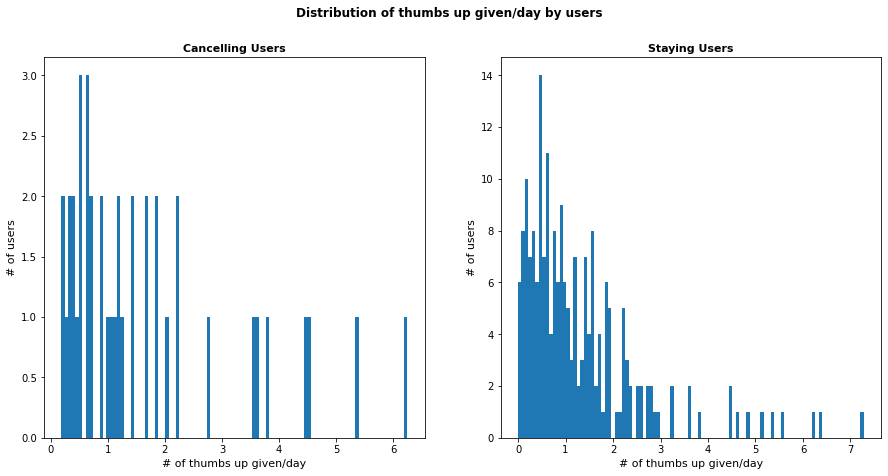

In [68]:
# Plot histogram for thumbs up
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs up given/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_up_day_canc, bins=100)
ax1.set_xlabel('# of thumbs up given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_up_day_stay, bins=100)
ax2.set_xlabel('# of thumbs up given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [69]:
# Look at the statistics
stats_thumbs_up_canc = spark.createDataFrame(thumbs_up_day_canc, FloatType()).describe().collect()
stats_thumbs_up_stay = spark.createDataFrame(thumbs_up_day_stay, FloatType()).describe().collect()

print('------------------------------------------------------------')
print('Thumbs up given per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_canc[2][1])))
print('------------------------------------------------------------')
print('Thumbs up given per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_stay[2][1])))
print('------------------------------------------------------------')

------------------------------------------------------------
Thumbs up given per day statistics for users that cancelled:
Mean =  1.63 ; Std. Dev. =  1.51
------------------------------------------------------------
Thumbs up given per day statistics for users that stay:
Mean =  1.30 ; Std. Dev. =  1.26
------------------------------------------------------------


We can check if anything changes during last week:

In [70]:
# Select, for every user that cancelled, the number of thumbs up given in the last week
thumbs_up_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_up")).collect()

In [71]:
# Get the number of thumbs up given per day, on average
thumbs_up_day_canc_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_up_canc_lweek]

In [72]:
# Select, for every user that is staying, the number of thumbs up given in the last week
thumbs_up_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_up")).collect()

In [73]:
# Get the number of thumbs up given per day, on average
thumbs_up_day_stay_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_up_stay_lweek]

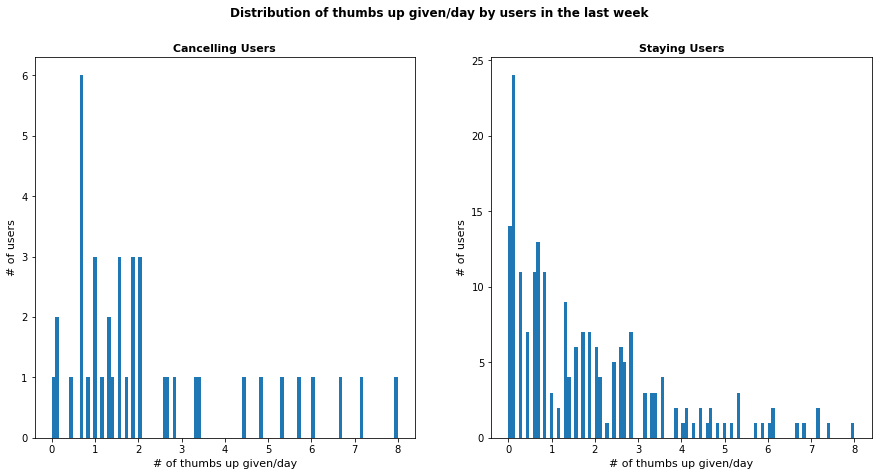

In [74]:
# Plot histogram for thumbs up
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs up given/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_up_day_canc_lweek, bins=100)
ax1.set_xlabel('# of thumbs up given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_up_day_stay_lweek, bins=100)
ax2.set_xlabel('# of thumbs up given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [75]:
# Look at the statistics
stats_thumbs_up_canc_lweek = spark.createDataFrame(thumbs_up_day_canc_lweek, FloatType()).describe().collect()
stats_thumbs_up_stay_lweek = spark.createDataFrame(thumbs_up_day_stay_lweek, FloatType()).describe().collect()

print('------------------------------------------------------------------------')
print('Thumbs up given per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_canc_lweek[2][1])))
print('------------------------------------------------------------------------')
print('Thumbs up given per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_stay_lweek[2][1])))
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Thumbs up given per day statistics for users that cancelled - last week:
Mean =  2.32 ; Std. Dev. =  2.07
------------------------------------------------------------------------
Thumbs up given per day statistics for users that stay - last week:
Mean =  1.82 ; Std. Dev. =  1.79
------------------------------------------------------------------------


#### 3.2.3. Thumbs down

In [76]:
# Select, for every user that cancelled, the number of thumbs down given and the time window of the analysis
thumbs_dwn_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_dwn")).collect()

In [77]:
# Get the number of thumbs down given, on average
thumbs_dwn_day_canc = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_dwn_canc]

In [78]:
# Select, for every user that is staying, the number of thumbs down given and the time window of the analysis
thumbs_dwn_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_dwn")).collect()

In [79]:
# Get the number of thumbs down given, on average
thumbs_dwn_day_stay = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_dwn_stay]

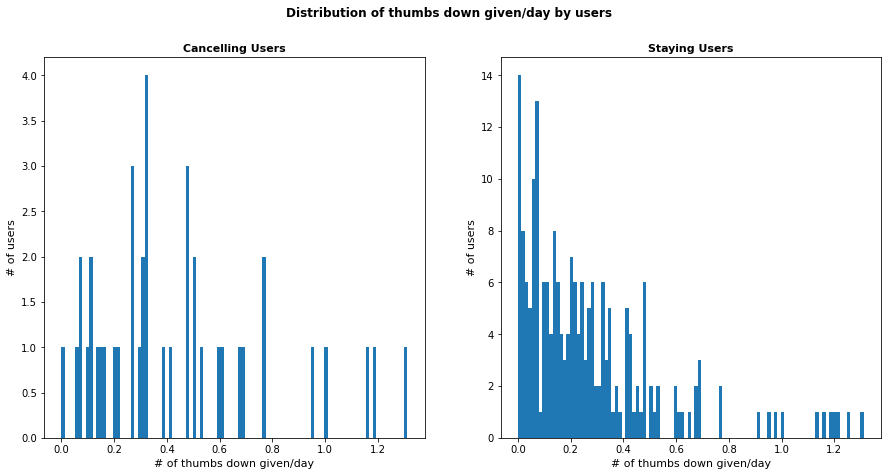

In [80]:
# Plot histogram for thumbs down
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs down given/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_dwn_day_canc, bins=100)
ax1.set_xlabel('# of thumbs down given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_dwn_day_stay, bins=100)
ax2.set_xlabel('# of thumbs down given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [81]:
# Look at the statistics
stats_thumbs_dwn_canc = spark.createDataFrame(thumbs_dwn_day_canc, FloatType()).describe().collect()
stats_thumbs_dwn_stay = spark.createDataFrame(thumbs_dwn_day_stay, FloatType()).describe().collect()

print('--------------------------------------------------------------')
print('Thumbs down given per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_canc[2][1])))
print('--------------------------------------------------------------')
print('Thumbs down per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_stay[2][1])))
print('--------------------------------------------------------------')

--------------------------------------------------------------
Thumbs down given per day statistics for users that cancelled:
Mean =  0.44 ; Std. Dev. =  0.33
--------------------------------------------------------------
Thumbs down per day statistics for users that stay:
Mean =  0.27 ; Std. Dev. =  0.27
--------------------------------------------------------------


We can check if anything changes during last week:

In [82]:
# Select, for every user that cancelled, the number of thumbs down given in the last week
thumbs_dwn_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_dwn")).collect()

In [83]:
# Get the number of thumbs down given per day, on average
thumbs_dwn_day_canc_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_dwn_canc_lweek]

In [84]:
# Select, for every user that is staying, the number of thumbs down given in the last week
thumbs_dwn_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_dwn")).collect()

In [85]:
# Get the number of thumbs down given per day, on average
thumbs_dwn_day_stay_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_dwn_stay_lweek]

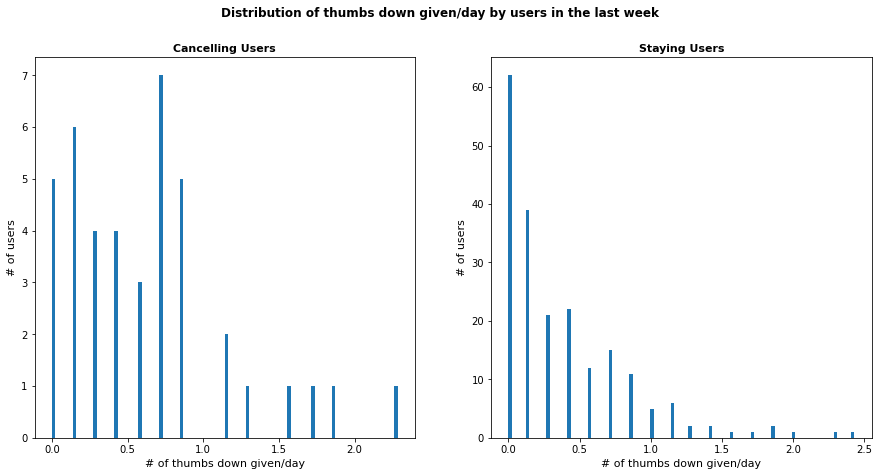

In [86]:
# Plot histogram for thumbs down
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs down given/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_dwn_day_canc_lweek, bins=100)
ax1.set_xlabel('# of thumbs down given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_dwn_day_stay_lweek, bins=100)
ax2.set_xlabel('# of thumbs down given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [87]:
# Look at the statistics
stats_thumbs_dwn_canc_lweek = spark.createDataFrame(thumbs_dwn_day_canc_lweek, FloatType()).describe().collect()
stats_thumbs_dwn_stay_lweek = spark.createDataFrame(thumbs_dwn_day_stay_lweek, FloatType()).describe().collect()

print('--------------------------------------------------------------------------')
print('Thumbs down given per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_canc_lweek[2][1])))
print('--------------------------------------------------------------------------')
print('Thumbs down given per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_stay_lweek[2][1])))
print('--------------------------------------------------------------------------')

--------------------------------------------------------------------------
Thumbs down given per day statistics for users that cancelled - last week:
Mean =  0.63 ; Std. Dev. =  0.54
--------------------------------------------------------------------------
Thumbs down given per day statistics for users that stay - last week:
Mean =  0.39 ; Std. Dev. =  0.46
--------------------------------------------------------------------------


### <a class="anchor" id="Upgrade-Downgrade">3.3. Submit an Upgrade/Downgrade request</a>

We can also take a look at how many upgrade/downgrade request can be found in the various datasets, and compare that to the number of users.

In [88]:
# Calculate number of downgrades/upgrades requests for the users that cancelled
downgrade_canc = df_user_log_cancelled.select(F.sum("sub_dwg")).collect()
upgrade_canc = df_user_log_cancelled.select(F.sum("sub_upg")).collect()

In [89]:
# Calculate number of downgrades/upgrades requests for the users that are staying
downgrade_stay = df_user_log_staying.select(F.sum("sub_dwg")).collect()
upgrade_stay = df_user_log_staying.select(F.sum("sub_upg")).collect()

In [90]:
# Look at the values and the proportions
print('-------------------------------------------------------------')
print('Downgrades/Upgrades requests/number of users that cancelled:')
print('Absolute Downgrades = ', downgrade_canc[0][0])
print('Absolute Upgrades = ', upgrade_canc[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_canc[0][0]/len(users_cancelled)))
print('Upgrades/Num. of Users = ', '{:.2f}'.format(upgrade_canc[0][0]/len(users_cancelled)))
print('-------------------------------------------------------------')
print('Downgrades/Upgrades requests/number of users that stay:')
print('Absolute Downgrades = ', downgrade_stay[0][0])
print('Absolute Upgrades = ', upgrade_stay[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_stay[0][0]/len(users_staying)))
print('Upgrades/Num. of Users = ', '{:.2f}'.format(upgrade_stay[0][0]/len(users_staying)))
print('-------------------------------------------------------------')

-------------------------------------------------------------
Downgrades/Upgrades requests/number of users that cancelled:
Absolute Downgrades =  9
Absolute Upgrades =  31
Downgrades/Num. of Users =  0.22
Upgrades/Num. of Users =  0.76
-------------------------------------------------------------
Downgrades/Upgrades requests/number of users that stay:
Absolute Downgrades =  63
Absolute Upgrades =  158
Downgrades/Num. of Users =  0.31
Upgrades/Num. of Users =  0.77
-------------------------------------------------------------


Let's take a look at the last week:

In [91]:
# Calculate number of downgrades/upgrades requests for the users that cancelled - last week of data
downgrade_canc_lweek = df_user_log_cancelled_lweek.select(F.sum("sub_dwg")).collect()
upgrade_canc_lweek = df_user_log_cancelled_lweek.select(F.sum("sub_upg")).collect()

In [92]:
# Calculate number of downgrades/upgrades requests for the users that are staying - last week of data
downgrade_stay_lweek = df_user_log_staying_lweek.select(F.sum("sub_dwg")).collect()
upgrade_stay_lweek = df_user_log_staying_lweek.select(F.sum("sub_upg")).collect()

In [93]:
# Look at the values and the proportions
print('-----------------------------------------------------------------------------')
print('Downgrades/Upgrades requests for users that cancelled - last week data:')
print('Absolute Downgrades = ', downgrade_canc_lweek[0][0])
print('Absolute Upgrades = ', upgrade_canc_lweek[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_canc_lweek[0][0]/len(users_cancelled_lweek)))
print('Upgrade/Num. of Users = ', '{:.2f}'.format(upgrade_canc_lweek[0][0]/len(users_cancelled_lweek)))
print('-----------------------------------------------------------------------------')
print('Downgrades/Upgrades requests/number of users that stay - last week data:')
print('Absolute Downgrades = ', downgrade_stay_lweek[0][0])
print('Absolute Upgrades = ', upgrade_stay_lweek[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_stay_lweek[0][0]/len(users_staying_lweek)))
print('Upgrade/Num. of Users = ', '{:.2f}'.format(upgrade_stay_lweek[0][0]/len(users_staying_lweek)))
print('-----------------------------------------------------------------------------')

-----------------------------------------------------------------------------
Downgrades/Upgrades requests for users that cancelled - last week data:
Absolute Downgrades =  3
Absolute Upgrades =  6
Downgrades/Num. of Users =  0.07
Upgrade/Num. of Users =  0.15
-----------------------------------------------------------------------------
Downgrades/Upgrades requests/number of users that stay - last week data:
Absolute Downgrades =  10
Absolute Upgrades =  20
Downgrades/Num. of Users =  0.05
Upgrade/Num. of Users =  0.10
-----------------------------------------------------------------------------


### <a class="anchor" id="Roll-Advert">3.4. Roll Advert</a>

In [94]:
# Select, for every user that cancelled, the number of rolled adverts and the time window of the analysis
rolled_advert_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_roll_adv")).collect()

In [95]:
# Get the rolled advert per day, on average
rolled_advert_day_canc = [rolled_advert[2]/rolled_advert[1] for rolled_advert in rolled_advert_canc]

In [96]:
# Select, for every user that is staying, the number of rolled adverts and the time window of the analysis
rolled_advert_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_roll_adv")).collect()

In [97]:
# Get the rolled advert per day, on average
rolled_advert_day_stay = [rolled_advert[2]/rolled_advert[1] for rolled_advert in rolled_advert_stay]

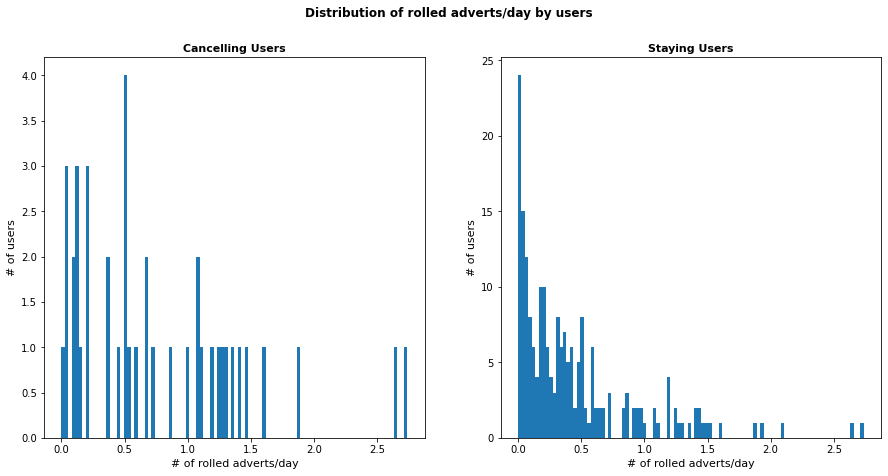

In [98]:
# Plot histogram for rolled advert
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of rolled adverts/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(rolled_advert_day_canc, bins=100)
ax1.set_xlabel('# of rolled adverts/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(rolled_advert_day_stay, bins=100)
ax2.set_xlabel('# of rolled adverts/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [99]:
# Look at the statistics
stats_rolled_advert_day_canc = spark.createDataFrame(rolled_advert_day_canc, FloatType()).describe().collect()
stats_rolled_advert_day_stay = spark.createDataFrame(rolled_advert_day_stay, FloatType()).describe().collect()

print('----------------------------------------------------------')
print('Rolled adverts per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_canc[2][1])))
print('----------------------------------------------------------')
print('Rolled adverts per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_stay[2][1])))
print('----------------------------------------------------------')

----------------------------------------------------------
Rolled adverts per day statistics for users that cancelled:
Mean =  0.76 ; Std. Dev. =  0.68
----------------------------------------------------------
Rolled adverts per day statistics for users that stay:
Mean =  0.44 ; Std. Dev. =  0.49
----------------------------------------------------------


Here too, we can take a look at what happens focusing on the last week of data:

In [100]:
# Select, for every user that cancelled, the number of rolled adverts in the last week of data
rolled_advert_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("roll_adv")).collect()

In [101]:
# Get the rolled advert per day, on average
rolled_advert_day_canc_lweek = [rolled_advert[1]/7 for rolled_advert in rolled_advert_canc_lweek]

In [102]:
# Select, for every user that is staying, the number of rolled adverts in the last week of data
rolled_advert_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("roll_adv")).collect()

In [103]:
# Get the rolled advert per day, on average
rolled_advert_day_stay_lweek = [rolled_advert[1]/7 for rolled_advert in rolled_advert_stay_lweek]

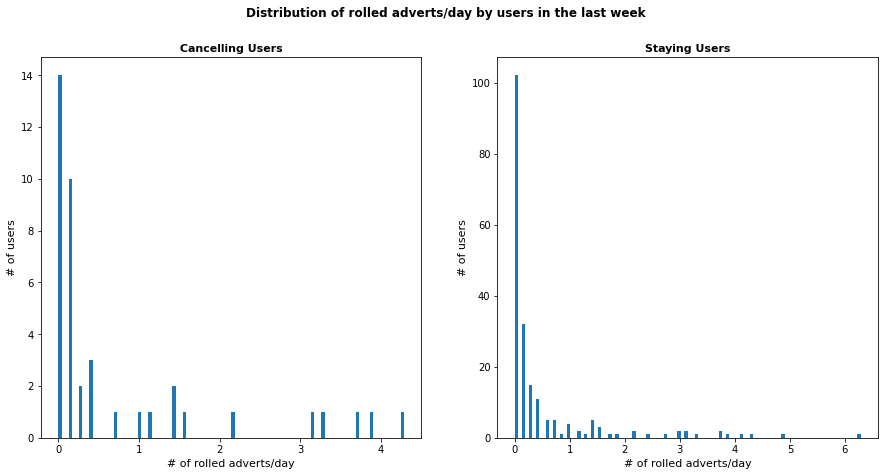

In [104]:
# Plot histogram for rolled advert
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of rolled adverts/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(rolled_advert_day_canc_lweek, bins=100)
ax1.set_xlabel('# of rolled adverts/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(rolled_advert_day_stay_lweek, bins=100)
ax2.set_xlabel('# of rolled adverts/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [105]:
# Look at the statistics
stats_rolled_advert_day_canc_lweek = spark.createDataFrame(rolled_advert_day_canc_lweek, FloatType()).describe().collect()
stats_rolled_advert_day_stay_lweek = spark.createDataFrame(rolled_advert_day_stay_lweek, FloatType()).describe().collect()

print('-----------------------------------------------------------------------')
print('Rolled adverts per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_canc_lweek[2][1])))
print('-----------------------------------------------------------------------')
print('Rolled adverts per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_stay_lweek[2][1])))
print('-----------------------------------------------------------------------')

-----------------------------------------------------------------------
Rolled adverts per day statistics for users that cancelled - last week:
Mean =  0.76 ; Std. Dev. =  1.22
-----------------------------------------------------------------------
Rolled adverts per day statistics for users that stay - last week:
Mean =  0.49 ; Std. Dev. =  1.00
-----------------------------------------------------------------------


### <a class="anchor" id="Demographics">3.5. Demographics</a>

As a final look at the data, we can explore the demographics of the users, in terms of gender or location:

In [106]:
# Parse the cancelled users to collect their gender
canc_user_gender = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.first("gender", True)).collect()

# Convert to list
canc_user_gender_list = [canc_user[1] for canc_user in canc_user_gender]

# Count males/females
num_canc_male_users = sum([user == 'M' for user in canc_user_gender_list])
num_canc_female_users = sum([user == 'F' for user in canc_user_gender_list])

In [107]:
# Parse the staying users to collect their gender
staying_user_gender = df_user_log_staying.\
                groupBy("userId").\
                agg(F.first("gender", True)).collect()

# Convert to list
staying_user_gender_list = [canc_user[1] for canc_user in staying_user_gender]

# Count males/females
num_staying_male_users = sum([user == 'M' for user in staying_user_gender_list])
num_staying_female_users = sum([user == 'F' for user in staying_user_gender_list])

In [108]:
# Look at the values and the proportions
print('-----------------------------------------------------------------------------')
print('Gender distribution for users that cancelled:')
print('Number of male users = ', num_canc_male_users)
print('Number of female users = ', num_canc_female_users)
print('Number of male users/Total Users = ', '{:.2f}'.format(num_canc_male_users/len(users_cancelled)))
print('Number of female users/Total Users = ', '{:.2f}'.format(num_canc_female_users/len(users_cancelled_lweek)))
print('-----------------------------------------------------------------------------')
print('Gender distribution for users that stay:')
print('Number of male users = ', num_staying_male_users)
print('Number of female users = ', num_staying_female_users)
print('Number of male users/Total Users = ', '{:.2f}'.format(num_staying_male_users/len(users_staying)))
print('Number of female users/Total Users = ', '{:.2f}'.format(num_staying_female_users/len(users_staying)))
print('-----------------------------------------------------------------------------')

-----------------------------------------------------------------------------
Gender distribution for users that cancelled:
Number of male users =  24
Number of female users =  17
Number of male users/Total Users =  0.59
Number of female users/Total Users =  0.41
-----------------------------------------------------------------------------
Gender distribution for users that stay:
Number of male users =  108
Number of female users =  96
Number of male users/Total Users =  0.53
Number of female users/Total Users =  0.47
-----------------------------------------------------------------------------


In [109]:
# Parse the cancelled users to collect their location
canc_user_location = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.first("location", True)).collect()

# Get the state only
canc_user_state = [user_loc[1].split(', ')[1] for user_loc in canc_user_location]

# Count the occurrences and store tham as 2D list
canc_state_counts_list = [[x, canc_user_state.count(x)] for x in set(canc_user_state)] 

# Sort the states alphabetically
canc_state_counts_list.sort(key=lambda l:l[0])

# Convert to an array, for convenience in slicing
canc_state_counts = np.array(canc_state_counts_list)

In [110]:
# Parse the staying users to collect their location
staying_user_location = df_user_log_staying.\
                groupBy("userId").\
                agg(F.first("location")).collect()

# Get the state only
stay_user_state = [user_loc[1].split(', ')[1] for user_loc in staying_user_location]

# Count the occurrences and store tham as 2D list
stay_state_counts_list = [[x, stay_user_state.count(x)] for x in set(stay_user_state)] 

# Sort the states alphabetically
stay_state_counts_list.sort(key=lambda l:l[0])

# Convert to an array, for convenience in slicing
stay_state_counts = np.array(stay_state_counts_list)

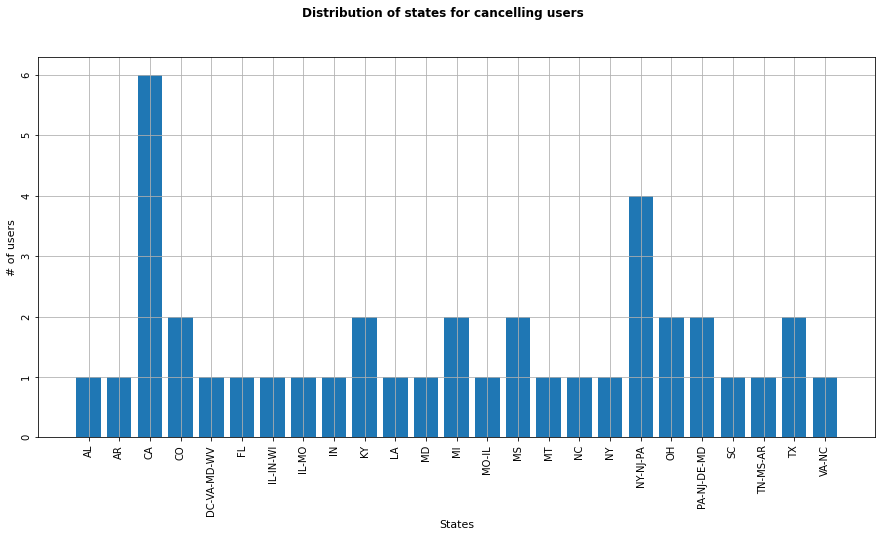

In [111]:
# Plot bar chart for state location (1/2)
fig, ax = plt.subplots(1, 1)

fig.suptitle('Distribution of states for cancelling users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

x_coord = canc_state_counts[0:-1, 0].tolist()
y_coord = [int(y_c) for y_c in canc_state_counts[0:-1, 1].tolist()]

ax.bar(x_coord, y_coord)
ax.set_xlabel('States', fontsize=11)
ax.set_ylabel('# of users', fontsize=11)

ax.tick_params(labelrotation = 90)
ax.grid()

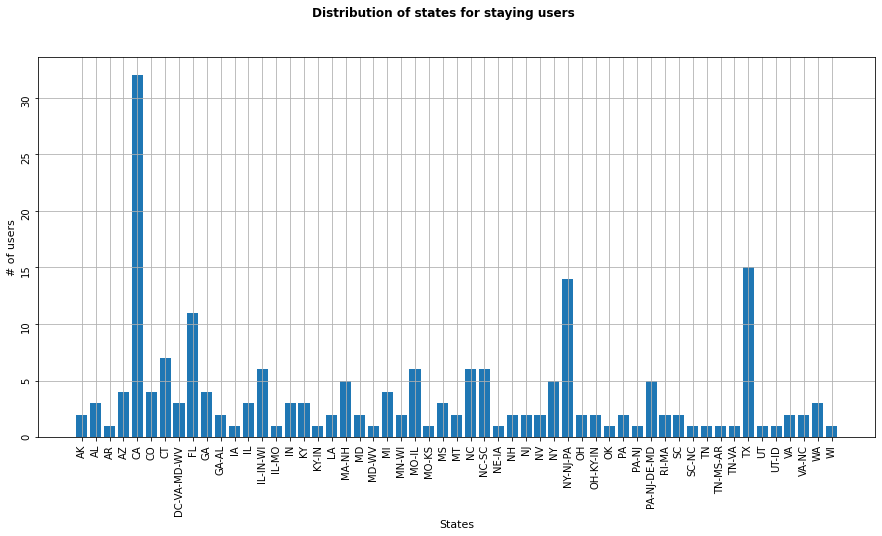

In [112]:
# Plot bar chart for state location (2/2)
fig, ax = plt.subplots(1, 1)

fig.suptitle('Distribution of states for staying users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

x_coord = stay_state_counts[0:-1, 0].tolist()
y_coord = [int(y_c) for y_c in stay_state_counts[0:-1, 1].tolist()]

ax.bar(x_coord, y_coord)
ax.set_xlabel('States', fontsize=11)
ax.set_ylabel('# of users', fontsize=11)
ax.tick_params(labelrotation = 90)
ax.grid()

## <a class="anchor" id="Feature-Engineering">4. Feature Engineering</a>

Based on the above analysis, I will consider as features to be used for the modeling phase:

* The number of rolled adverts/day
* The number of friends added/day
* The number of thumbs down given/day
* The number of songs listened/day
* The time spent with the service


The label will be the actual churning event.

I couldn't see any evidence of a sgnificant difference in the behaviour of the users in the last week before churning vs. the behaviour before, so I will consider their full history.  
All the features will be grouped by `userId`.

In [113]:
# Select the columns
df_user_logs_red = df_user_log_valid.\
    select(["userId", "total_roll_adv", "total_add_friend", "thumbs_dwn", "song", "data_days", "perm_days", "churn"])

In [114]:
# Group by users
df_user_logs_group = df_user_logs_red.\
    groupby("userId").\
    agg(F.max("total_roll_adv")/F.max("data_days"), \
        F.max("total_add_friend")/F.max("data_days"), \
        F.max("thumbs_dwn")/F.max("data_days"), \
        F.countDistinct("song")/F.max("data_days"), F.max("perm_days"), F.max("churn")).collect()

In [115]:
# Introduce a schema, defining the churn colums as the label to identify
schema = ["id","rolledAdvDay","addedFriendDay","thumbsDwnDay","songsDay","permanence","label"]

In [116]:
# Create a dataframe
df_user_logs_mod = spark.createDataFrame(data = df_user_logs_group, schema = schema)

In [117]:
# Check the data
df_user_logs_mod.head()

Row(id='100010', rolledAdvDay=1.1818181818181819, addedFriendDay=0.09090909090909091, thumbsDwnDay=0.022727272727272728, songsDay=6.113636363636363, permanence=56.0, label=0)

## <a class="anchor" id="Modeling">5. Modeling</a>

Once created the dataframe, we can split between train and test:

In [118]:
# 80/20 % split
train, test = df_user_logs_mod.randomSplit([0.8, 0.2], seed=42)

In [119]:
# Check size of the datasets
print('Num. of samples in training dataset: ', train.count())
print('Num. of samples in test dataset: ',  test.count())

Num. of samples in training dataset:  162
Num. of samples in test dataset:  42


In [120]:
# Check sample in train dataset
train.head()

Row(id='100010', rolledAdvDay=1.1818181818181819, addedFriendDay=0.09090909090909091, thumbsDwnDay=0.022727272727272728, songsDay=6.113636363636363, permanence=56.0, label=0)

In [121]:
# Check sample in test dataset
test.head()

Row(id='100021', rolledAdvDay=0.6666666666666666, addedFriendDay=0.15555555555555556, thumbsDwnDay=0.022222222222222223, songsDay=5.022222222222222, permanence=65.0, label=1)

Once split the data we can building a ML training pipeline.  

First, we will define a [VectorAssembler](https://spark.apache.org/docs/latest/ml-features#vectorassembler) to combine all the features of interest in a single vector:

In [122]:
# Define VectorAssembler
assembler = VectorAssembler(inputCols=["rolledAdvDay",\
                                       "addedFriendDay",\
                                       "thumbsDwnDay",\
                                       "songsDay",\
                                       "permanence"], \
                            outputCol="inputFeatures")

Then we scale the data using a [Min-Max Scaler](https://spark.apache.org/docs/latest/ml-features#minmaxscaler). I opted for this given that the distributions of the various features (as seen in the data exploration section) are quite skewed and far from resembling the normal one.

In [123]:
# Define Scaler
scaler = MinMaxScaler(inputCol="inputFeatures", outputCol="features")

Finally we introduce the classifier.

There are several possibilities in [Spark](https://spark.apache.org/docs/latest/ml-classification-regression.html). I picked a few to run in different pipelines to evaluate different results. 

In [124]:
# Classifiers/Pipelines

# Logistic Regression 
lr = LogisticRegression()
pipeline_lr = Pipeline(stages = [assembler, scaler, lr])

# Gradient-Boosted Tree classifier
gbt = GBTClassifier()
pipeline_gbt = Pipeline(stages = [assembler, scaler, gbt])

# Random Forest classifier
# Note: setting the seed will ensure repeatability of the results
rf = RandomForestClassifier(seed = 42)
pipeline_rf = Pipeline(stages = [assembler, scaler, rf])

# Linear Support Vector Machine classifier
lsvc = LinearSVC()
pipeline_svc = Pipeline(stages = [assembler, scaler, lsvc])

For each of the previous pipeline we will see in the follow the fitting and evaluation steps making use of the f1-score, as an evaluation metric, given the imbalance between 0/1 in the data (there are much more users `not` churning than churning).

In [125]:
# Evaluator - will be common for all the grids
evaluator = MulticlassClassificationEvaluator(metricName="f1")

In the following cells we'll fit all the 4 pipeline with the default parameters, and see the various results.

### <a class="anchor" id="Logistic-Regression">5.1. Logistic Regression</a>

In [126]:
paramgrid_lr = ParamGridBuilder()\
    .build()

# Crossvalidator 
crossval_lr = CrossValidator(estimator = pipeline_lr, \
                             estimatorParamMaps = paramgrid_lr, \
                             evaluator = evaluator, \
                             numFolds = 3, \
                             seed = 4242)

In [127]:
# Train
cvModel_lr = crossval_lr.fit(train) 

In [128]:
# Evaluate
f1_Score_lr = evaluator.evaluate(cvModel_lr.transform(test))

print('F1-score, Logistic Regression classifier: ','{:.4f}'.format(f1_Score_lr))

F1-score, Logistic Regression classifier:  0.8828


### <a class="anchor" id="Gradient-Boosted-Tree">5.2. Gradient-Boosted Tree</a>

In [129]:
# Parameter grid
paramgrid_gbt = ParamGridBuilder()\
    .build()

# Crossvalidator 
crossval_gbt = CrossValidator(estimator = pipeline_gbt, \
                              estimatorParamMaps = paramgrid_gbt, \
                              evaluator = evaluator, \
                              numFolds = 3, \
                              seed = 4242)

In [130]:
# Train
cvModel_gbt = crossval_gbt.fit(train) 

In [131]:
# Evaluate
f1_Score_gbt = evaluator.evaluate(cvModel_gbt.transform(test))

print('F1-score, Gradient-Boosted Tree classifier: ','{:.4f}'.format(f1_Score_gbt))

F1-score, Gradient-Boosted Tree classifier:  0.8190


### <a class="anchor" id="Random-Forest">5.3. Random Forest</a>

In [132]:
# Parameter grid
paramgrid_rf = ParamGridBuilder()\
    .build()

# Crossvalidator 
crossval_rf = CrossValidator(estimator = pipeline_rf, \
                             estimatorParamMaps = paramgrid_rf, \
                             evaluator = evaluator, \
                             numFolds = 3, \
                             seed = 4242)

In [133]:
# Train
cvModel_rf = crossval_rf.fit(train) 

In [134]:
# Evaluate
f1_Score_rf = evaluator.evaluate(cvModel_rf.transform(test))

print('F1-score, Random Forest classifier: ','{:.4f}'.format(f1_Score_rf))

F1-score, Random Forest classifier:  0.8095


### <a class="anchor" id="Linear-SVC">5.4. Linear SVC</a>

In [135]:
# Parameter grid
paramgrid_svc = ParamGridBuilder()\
    .build()

# Crossvalidator 
crossval_svc = CrossValidator(estimator = pipeline_svc, \
                              estimatorParamMaps = paramgrid_svc, \
                              evaluator = evaluator, \
                              numFolds = 3, \
                              seed = 4242)

In [136]:
# Train
cvModel_svc = crossval_svc.fit(train) 

In [137]:
# Evaluate
f1_Score_svc = evaluator.evaluate(cvModel_svc.transform(test))

print('F1-score, Linear Support Vector Machine classifier: ','{:.4f}'.format(f1_Score_svc))

F1-score, Linear Support Vector Machine classifier:  0.8302


## <a class="anchor" id="Optimization">6. Optimization</a>

Given the previous results with the default parameters, we can now try to explore the parameters'grids to see whether or not the performances of the models can be improved.  
In particular, I will define optimization grids for both the Gradient Boosted Tree and the Random Forest classifiers.

### <a class="anchor" id="Optimized-Gradient-Boosted-Tree">6.1. Gradient-Boosted Tree</a>

In [138]:
# Parameter grid
paramgrid_gbt_o = ParamGridBuilder()\
    .addGrid(gbt.stepSize, [0.1, 0.25, 0.5])\
    .addGrid(gbt.maxIter, [20, 40, 60])\
    .build()

# Crossvalidator 
crossval_gbt_o = CrossValidator(estimator = pipeline_gbt, \
                                estimatorParamMaps = paramgrid_gbt_o, \
                                evaluator = evaluator, \
                                numFolds = 3, \
                                seed = 4242)

In [139]:
# Train
cvModel_gbt_o = crossval_gbt_o.fit(train) 

In [140]:
# Evaluate
f1_Score_gbt = evaluator.evaluate(cvModel_gbt_o.transform(test))

print('F1-score, Gradient-Boosted Tree classifier: ','{:.4f}'.format(f1_Score_gbt))

F1-score, Gradient-Boosted Tree classifier:  0.8401


Once optimized, we can take a look at the parameters actually chosen through the code here below:

In [141]:
bestGBTPipeline = cvModel_gbt_o.bestModel
bestGBTModel = bestGBTPipeline.stages[2]
bestGBTParams = bestGBTModel.extractParamMap()
bestGBTParams

{Param(parent='GBTClassifier_dcd290a558a7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_dcd290a558a7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_dcd290a558a7', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

### <a class="anchor" id="Optimized-Random-Forest">6.2. Random Forest</a>

In [142]:
# Parameter grid
paramgrid_rf_o = ParamGridBuilder()\
    .addGrid(rf.impurity, ['entropy', 'gini'])\
    .addGrid(rf.maxDepth, [5, 10])\
    .addGrid(rf.numTrees, [20, 40])\
    .build()

# Crossvalidator 
crossval_rf_o = CrossValidator(estimator = pipeline_rf, \
                               estimatorParamMaps = paramgrid_rf_o, \
                               evaluator = evaluator, \
                               numFolds = 3, \
                               seed = 4242)

In [143]:
# Train
cvModel_rf_o = crossval_rf_o.fit(train) 

In [144]:
# Evaluate
f1_Score_rf = evaluator.evaluate(cvModel_rf_o.transform(test))

print('F1-score, Random Forest classifier: ','{:.4f}'.format(f1_Score_rf))

F1-score, Random Forest classifier:  0.8302


Also in this case we can take a look at the resulting optimized parameters:

In [145]:
bestRFPipeline = cvModel_rf_o.bestModel
bestRFModel = bestRFPipeline.stages[2]
bestRFParams = bestRFModel.extractParamMap()
bestRFParams

{Param(parent='RandomForestClassifier_2c3ed5c65333', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_2c3ed5c65333', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_2c3ed5c65333', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_2c3ed5c65333', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

## <a class="anchor" id="Modeling">6.1. Logistic Regression</a>

In [ ]:
paramgrid_lr_o = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter, [100, 250, 500])\
    .build()

# Crossvalidator 
crossval_lr_o = CrossValidator(estimator = pipeline_lr, \
                               estimatorParamMaps = paramgrid_lr_o, \
                               evaluator = evaluator, \
                               numFolds = 3, \
                               seed = 4242)

In [ ]:
# Train
t0= time.clock()

cvModel_lr_o = crossval_lr_o.fit(train) 


t1 = time.clock()
# print('Done. Elapsed time = ', '{:.2f}'.format(t1))
print('Done. Elapsed time = ', t1 - t0)
print(t1, t0)

In [ ]:
# Evaluate
f1_Score_lr = evaluator.evaluate(cvModel_lr_o.transform(test))

print('F1-score, Logistic Regression classifier: ','{:.4f}'.format(f1_Score_lr))

In [ ]:
bestPipeline = cvModel_lr_o.bestModel
bestLRModel = bestPipeline.stages[2]
bestLRParams = bestLRModel.extractParamMap()

In [ ]:
bestLRParams

### <a class="anchor" id="Linear-SVC">6.4. Linear SVC</a>

In [ ]:
# Parameter grid
paramgrid_svc_o = ParamGridBuilder()\
    .addGrid(lsvc.regParam, [0.0, 0.5, 1.0])\
    .addGrid(lsvc.maxIter, [100, 250, 500])\
    .build()

# Crossvalidator 
crossval_svc_o = CrossValidator(estimator = pipeline_svc, \
                                estimatorParamMaps = paramgrid_svc_o, \
                                evaluator = evaluator, \
                                numFolds = 3, \
                                seed = 4242)

In [ ]:
# Train
t0= time.clock()

cvModel_svc_o = crossval_svc_o.fit(train) 

t1 = time.clock()
# print('Done. Elapsed time = ', '{:.2f}'.format(t1))
print('Done. Elapsed time = ', t1 - t0)
print(t1, t0)

In [ ]:
# Evaluate
f1_Score_svc = evaluator.evaluate(cvModel_svc_o.transform(test))

print('F1-score, Linear Support Vector Machine classifier: ','{:.4f}'.format(f1_Score_svc))

In [ ]:
bestPipeline = cvModel_svc_o.bestModel
bestSVCModel = bestPipeline.stages[2]
bestSVCParams = bestSVCModel.extractParamMap()

In [ ]:
bestSVCParams

In [ ]:
train_tran = assembler.transform(train)

In [ ]:
scaler2 = MinMaxScaler(inputCol="inputFeatures", outputCol="features")
scaler_obj = scaler2.fit(train_tran)

In [ ]:
scaler_obj.getMin(), scaler_obj.getMax()

In [ ]:
train_scal = scaler_obj.transform(train_tran)

In [ ]:
train_scal.head()

In [ ]:
train_scal.select('features').head()

In [ ]:
train_scal.agg({'songsDay': 'min'}).collect()[0][0]

In [ ]:
train_scal_pd = train_scal.toPandas()
train_scal_pd.head()

In [ ]:
fts = train_scal_pd.features.loc[0].tolist()
fts

In [ ]:
any(ft < 0 for ft in fts)

In [ ]:
for ii in range(train_scal_pd.shape[0]):
    fts = train_scal_pd.features.loc[ii].tolist()
    if any(ft < 0 for ft in fts):
        print("Found")
        print(fts, ii)
        break

In [ ]:
for ii in range(train_scal_pd.shape[0]):
    fts = train_scal_pd.features.loc[ii].tolist()
    #0.03320158102766799,0.0877742946708464,0.0,-0.0011134383606826012,0.34728033472803344
    if ((fts[0] > 0.033) & (fts[0]<0.034)):
        print(fts, ii)

In [ ]:
nb2 = NaiveBayes()

In [ ]:
nb2.fit(train_scal)

In [ ]:
nbModel2 = pipeline_nb.fit(train)

In [ ]:
# Check what happens to the first userID leaving
# user_canc_0_lifecycle = df_user_log_valid.select(["userId", "firstname", "page", "level", "ts"]).\
#     where(df_user_log_valid.userId == users_cancelled[12][0]).collect()

In [ ]:
# len(user_canc_0_lifecycle)

In [ ]:
# The beginning...
# user_canc_0_lifecycle[:10]

In [ ]:
# ... the end
# user_canc_0_lifecycle[400:450]

As a variable of interest we can consider the amount of time spent with the service:

In [ ]:
# How much time did he/she spend with the service:
# print('Example of a user leaving the service:')
# print('Date when joining: ', datetime.fromtimestamp(user_canc_0_lifecycle[0][4]/1000))
# print('Date when leaving: ', datetime.fromtimestamp(user_canc_0_lifecycle[-1][4]/1000))
      
# # Quantify that time in days...
# print('Interval in days: ', '{:.3f}'.format((user_canc_0_lifecycle[-1][4]/1000 - user_canc_0_lifecycle[0][4]/1000)\
#                                             /(3600*24)))

We can take a look at the same metric for a user that stayed with the service:

In [ ]:
# First userID staying
# user_stay_0_lifecycle = user_log_valid.select(["userId", "firstname", "page", "level", "ts"]).\
#     where(user_log_valid.userId == users_staying[0][0]).collect()

# # How much time did he/she spend with the service:
# print('Example of a user staying with the service:')
# print('Date when joining: ', datetime.fromtimestamp(user_stay_0_lifecycle[0][4]/1000))
# print('Last date recorded: ', datetime.fromtimestamp(user_stay_0_lifecycle[-1][4]/1000))
      
# # Quantify that time in days...
# print('Interval in days: ', '{:.3f}'.format((user_stay_0_lifecycle[-1][4]/1000 - user_stay_0_lifecycle[0][4]/1000)\
#                                             /(3600*24)))

We can check the quantiles for the num of songs/day

In [ ]:
spark.createDataFrame(num_songs_cancelled, FloatType()).approxQuantile("value", [0.25, 0.5, 0.75], 0.25)

In [ ]:
spark.createDataFrame(num_songs_staying, FloatType()).approxQuantile("value", [0.25, 0.5, 0.75], 0.25)

In [ ]:
user_log_cancelled.head()

In [ ]:
user_log_staying.head()

Added friend event:

Rolled advert event:

In [ ]:
rolled_advert_canc = user_log_cancelled.\
                groupBy("userId").\
                agg(min("ts"), max("ts"), Ssum("roll_adv")).collect()

In [ ]:
rolled_advert_event_canc = [rolled_adv[3]/math.ceil((rolled_adv[2]/1000 - rolled_adv[1]/1000)/(3600*24))\
                            for rolled_adv in rolled_advert_canc]

In [ ]:
rolled_advert_stay = user_log_staying.\
                groupBy("userId").\
                agg(min("ts"), max("ts"), Ssum("roll_adv")).collect()

In [ ]:
rolled_advert_event_stay = [rolled_adv[3]/math.ceil((rolled_adv[2]/1000 - rolled_adv[1]/1000)/(3600*24)) \
                            for rolled_adv in rolled_advert_stay]

In [ ]:
# Plot histogram for rolled advert
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of rolled advert event', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(rolled_advert_event_canc, bins=100)
ax1.set_xlabel('# of rolled adverts/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(rolled_advert_event_stay, bins=100)
ax2.set_xlabel('# of rolled adverts/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

In [ ]:
# Look at the statistics
print('Statistics for rolled advert/day for users that cancelled:')
spark.createDataFrame(rolled_advert_event_canc, FloatType()).describe().show()

In [ ]:
# Look at the statistics
print('Statistics for rolled advert/day for users that stay:')
spark.createDataFrame(rolled_advert_event_stay, FloatType()).describe().show()

**Downgrade plan**

In [ ]:
# Defining a dwg variable based on the the change of level from "paid" to "free"

In [ ]:
# Defining a sub_dwg variable based on the Submit Downgrade page
sub_dwg = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())  

user_log_cancelled = user_log_cancelled.withColumn("sub_dwg", sub_dwg("page"))
user_log_staying = user_log_staying.withColumn("sub_dwg", sub_dwg("page"))

In [ ]:
user_log_cancelled.head()

In [ ]:
user_log_staying.head()

In [ ]:
downgrade_canc[0][0], downgrade_stay[0][0]

In [ ]:
# Defining a pay_plan variable based on the Level page
pay_plan = udf(lambda x: 1 if x == "paid" else 0, IntegerType())  

user_log_cancelled = user_log_cancelled.withColumn("pay_plan", pay_plan("level"))
user_log_staying = user_log_staying.withColumn("pay_plan", pay_plan("level"))

In [ ]:
user_log_cancelled.head()

In [ ]:
user_log_staying.head()

In [ ]:
pay_plan_canc = user_log_cancelled.\
                groupBy("userId").\
                agg(max("pay_plan")).collect()

In [ ]:
pay_plan_canc_list = [pay_plan_status[1] for pay_plan_status in pay_plan_canc]

In [ ]:
pay_plan_stay = user_log_staying.\
                groupBy("userId").\
                agg(max("pay_plan")).collect()

In [ ]:
pay_plan_stay_list = [pay_plan_status[1] for pay_plan_status in pay_plan_stay]

In [ ]:
sum(pay_plan_canc_list), sum(pay_plan_stay_list)

In [ ]:
downgrade_canc[0][0]/sum(pay_plan_canc_list), downgrade_stay[0][0]/sum(pay_plan_stay_list)

In [ ]:
# window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# user_log_valid_2 = user_log_valid.withColumn("Schurn", Ssum("churn").over(window))

In [ ]:
# user_log_valid_2.head()

In [ ]:
# user_log_valid_2.tail(5)

In [ ]:
# df_user_log_staying_lweek.head()

In [ ]:
# Check what happens to the first userID leaving
# user_stay_0_lifecycle = df_user_log_staying_lweek.select(["userId", "firstname", "page", "level", "ts", "last_ts", \
#                                                           "registration", "first_ts", "perm_days", "data_days"]).\
#     where(df_user_log_staying_lweek.userId == users_staying_lweek[0][0]).collect()

In [ ]:
# len(user_stay_0_lifecycle)

In [ ]:
# # The beginning...
# user_stay_0_lifecycle[:10]

In [ ]:
# # ... the end
# user_stay_0_lifecycle[-10:]

In [ ]:
# user_stay_0_lifecycle[0][4], user_stay_0_lifecycle[-1][4],  \
# (user_stay_0_lifecycle[-1][4] - user_stay_0_lifecycle[0][4])/(3600*24)

In [ ]:
# # Check what happens to the first userID leaving
# user_stay_0_lifecycle_2 = df_user_log_staying.select(["userId", "firstname", "page", "level", "ts", "last_ts", \
#                                                           "registration", "first_ts", "perm_days", "data_days"]).\
#     where(df_user_log_staying.userId == users_staying_lweek[0][0]).collect()

In [ ]:
# len(user_stay_0_lifecycle_2)

In [ ]:
# The beginning...
# user_stay_0_lifecycle_2[:10]

In [ ]:
# ... the end
# user_stay_0_lifecycle_2[-35:]

In [ ]:
# user_stay_0_lifecycle_2[0][4], user_stay_0_lifecycle_2[-1][4],  \
# (user_stay_0_lifecycle_2[-1][4] - user_stay_0_lifecycle_2[0][4])/(3600*24)

In [ ]:
# (1542818132.0 - 1541750940.0)/(3600*24)

In [ ]:
# # Select, for every user that stays, the number of songs they listened in the last week
# delta_time_stay_lweek = df_user_log_staying_lweek.\
#                 filter(df_user_log_staying_lweek["song"] != "").\
#                 groupBy("userId").\
#                 agg(F.min("ts"), F.max("ts")).\
#                 collect()

In [ ]:
# delta_t = [delta[2] - delta[1] for delta in delta_time_stay_lweek]

In [ ]:
# min(delta_t), delta_t.index(min(delta_t))

In [ ]:
# delta_t[22], delta_time_stay_lweek[22]

In [ ]:
# # Check what happens to the first userID leaving
# user_stay_0_lifecycle_2 = df_user_log_staying_lweek.select(["userId", "firstname", "page", "level", "ts", "last_ts", \
#                                                           "registration", "first_ts", "perm_days", "data_days","song"]).\
#     where(df_user_log_staying_lweek.userId == '200010').collect()

In [ ]:
# len(user_stay_0_lifecycle_2)

In [ ]:
# user_stay_0_lifecycle_2

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.